In [1]:
import numpy as np
np.set_printoptions(precision=3)

from np2latex.np2latex import np2latex

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#plt.style.use('ggplot')

from qr import (power_iteration, power_iteration_matrix, 
                simultaneous_orthogonalization, qr_algorithm,
                plot_vector, plot_basis)

/Users/matthewdrury/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# So Just How Do You Calculate Eigenvalues Anyway?

The two most practically important problems in computational mathematics are solving systems of linear equations, and computing eigenvalues and eigenvectors.  We've already discussed a method for solving linear equations in [A Deep Dive Into How R Fits a Linear Model](http://madrury.github.io/jekyll/update/statistics/2016/07/20/lm-in-R.html), so I thought we could complete the circle with a discussion of computing eigenvalues and eigenvectors.

The standard algorithm for computing eigenvalues is called the $QR$-algorithm.  As the reader can surely guess, this involves the $QR$-factorization of the matrix in question.

The details of the $QR$-algorithm are mysterious.  Suppose we are interested in computing the eigenvalues of a matrix $A$.  Indeed, the first step of the $QR$-algorithm is to factor $A$ into the product of an orthogonal and an upper triangular matrix

$$ A = Q_0 R_0 $$

The next step is the mystery" we proceed by multiplying the factors in the *reverse order*

$$ A_1 = R_0 Q_0 $$

This is quite a bizzare thing to do.  There is no immediate geometric or intuitive interpretation of multiplying two matricies in reverse order.  The algorithm then iterates this factor-and-reverse process

$$ A_1 = Q_1 R_1 $$
$$ A_2 = R_1 Q_1 $$
$$ A_2 = Q_2 R_2 $$

...and so on.  For some arcane reason, this process eventually leads us (in the limit) to an upper triangular matrix, and the diagonal entries on this convergent are the eigenvalues of $A$.  Who knew?

In this essay we will hopefully de-misfy this process, and give the reader some insight into this very important algorithm.

### Software

I first learned about the $QR$-algorithm when writing [this C library](https://github.com/madrury/linalg), which implements many of the standard numerical linear algebric algorithms.  In this post, I will be providing python code implementing the various algorithms, as this will be more accessable to many readers.

To help with the numerous numpy arrays that needed to be typeset as matricies in latex, I wrote this small python package: [np2latex](https://github.com/madrury/np2latex).  May it go some way to relieving the reader's tedium as well.

### Acknowledgements

The imutus to write this material down was a question from my student [Michael Campbell](https://www.linkedin.com/in/michaelcampbell1988/).

## Setup

In [50]:
Q = np.array([
    [  0.00,  -0.80,  0.60],
    [ -0.80,  -0.36, -0.48],
    [ -0.60,   0.48,  0.64]
])

D = np.array([
    [9, 0, 0],
    [0, 4, 0],
    [0, 0, 1]
])

A = Q.T @ D @ Q

In [51]:
print(np2latex(A))

\left( \begin{array}{ccc} 2.92 & 0.86 & 1.15 \\ 0.86 & 6.51 & -3.32 \\ 1.15 & -3.32 & 4.57 \\ \end{array} \right)


In [52]:
print(np2latex(Q))
print(np2latex(D))

\left( \begin{array}{ccc} 0.00 & -0.80 & 0.60 \\ -0.80 & -0.36 & -0.48 \\ -0.60 & 0.48 & 0.64 \\ \end{array} \right)
\left( \begin{array}{ccc} 9.00 & 0.00 & 0.00 \\ 0.00 & 4.00 & 0.00 \\ 0.00 & 0.00 & 1.00 \\ \end{array} \right)


We will restrict ourselves to finding eigenvalues (and eigenvectors) of symmetric matricies $A$, and we will assume that $A$ has no repeated eigenvalues.  This is the most useful case in practice (for example, in finding the principal components of a data set $X$).

As a running example, we will take the matrix

$$ A = \left( \begin{array}{ccc} 2.92 & -0.86 & 1.15 \\ -0.86 & 6.51 & 3.32 \\ 1.15 & 3.32 & 4.57 \\ \end{array} \right) $$

This matrix was constructed as a product $Q^t D Q$, where

$$ Q = \left( \begin{array}{ccc} 0.00 & -0.80 & -0.60 \\ 0.80 & -0.36 & 0.48 \\ 0.60 & 0.48 & -0.64 \\ \end{array} \right) $$

is an orthogonal matrix, and

$$ D = \left( \begin{array}{ccc} 9.00 & 0.00 & 0.00 \\ 0.00 & 4.00 & 0.00 \\ 0.00 & 0.00 & 1.00 \\ \end{array} \right)$$

This immediately implies that $A$ is symmetric (which could also be verified by inspection), and that it has eigenvalues $\lambda_1 = 9.0, \lambda_2 = 4.0$, and $\lambda_3 = 1.0$.  The assoiated eigenvectors are the columns of $Q$.

We will often have need to visualize a matrix, especially orthogonal matricies.  To do so we will draw the columns of the matrix as vectors in $\mathbb{R}^3$.  For example, in this way we can visualize the matrix $Q$ as

/Users/matthewdrury/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


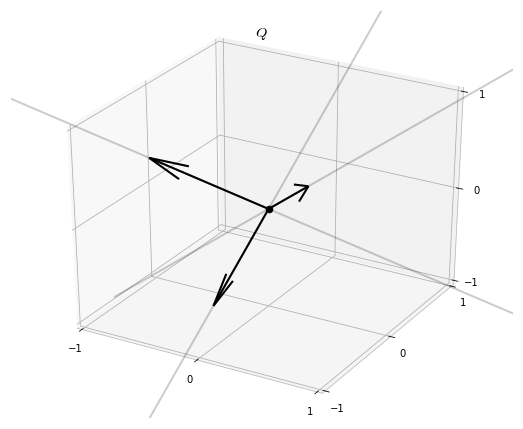

In [54]:
fig = plt.figure(figsize=(12*0.75, 10*0.75))
ax = fig.add_subplot(1, 1, 1, projection='3d', axisbg='white')
plot_basis(ax, Q, Q)
ax.set_title("$Q$")

## Working Example

In [45]:
e_vals, e_vectors = np.linalg.eig(A)

In [16]:
print(e_vals)
print(e_vectors)

[ 4.  1.  9.]
[[  8.000e-01  -6.000e-01  -3.872e-17]
 [ -3.600e-01  -4.800e-01   8.000e-01]
 [  4.800e-01   6.400e-01   6.000e-01]]


$$
\left(
    \begin{array}{ccc} 1 & 2 & 3 \\ 2 & 3 & 4 \\ 3 & 4 & 5 \\ \end{array}
\right)
$$

In [17]:
def make_row_format_string(n_columns, format_str=":2.2f"):
    return " & ".join(["{" + format_str + "}"]*n_columns) + r" \\"

In [18]:
print(make_row_format_string(3))

{:2.2f} & {:2.2f} & {:2.2f} \\


In [19]:
def numpy_to_latex(arr):
    n_cols = arr.shape[1]
    left = "\\left( \\begin{{array}}{{{}}} ".format('c'*arr.shape[1])
    right = " \\end{array} \\right)"
    rows = [make_row_format_string(n_cols).format(*row)
            for row in arr]
    return left + ' '.join(rows) + right

In [20]:
A

array([[ 2.92 , -0.864,  1.152],
       [-0.864,  6.509,  3.322],
       [ 1.152,  3.322,  4.571]])

In [21]:
print(numpy_to_latex(A))

\left( \begin{array}{ccc} 2.92 & -0.86 & 1.15 \\ -0.86 & 6.51 & 3.32 \\ 1.15 & 3.32 & 4.57 \\ \end{array} \right)


$$ \left( \begin{array}{ccc} 2.92 & -0.86 & 1.15 \\ -0.86 & 6.51 & 3.32 \\ 1.15 & 3.32 & 4.57 \\ \end{array} \right) $$

## Power Iteration

In [22]:
e, memo = power_iteration(A)

In [23]:
e

array([  6.880e-06,  -8.000e-01,  -6.000e-01])

/Users/matthewdrury/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


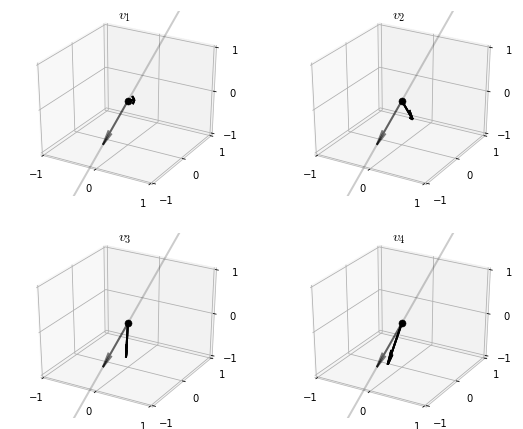

In [24]:
fig = plt.figure(figsize=(12*0.75, 10*0.75))

for i, v in enumerate(memo[:4]):
    ax = fig.add_subplot(2, 2, i+1, projection='3d', axisbg='white')
    plot_vector(ax, v, e)
    ax.set_title("$v_{{{}}}$".format(i+1))

## Convergence with an Orthogonal Vector

In [25]:
e, memo = power_iteration(A, v=[1, 0, 0])

/Users/matthewdrury/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


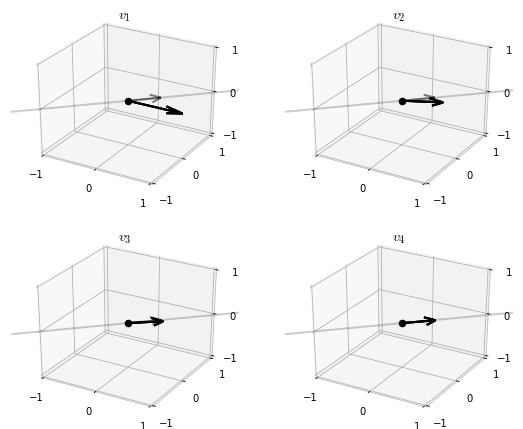

In [26]:
fig = plt.figure(figsize=(12*0.75, 10*0.75))

for i, v in enumerate(memo[:4]):
    ax = fig.add_subplot(2, 2, i+1, projection='3d', axisbg='white')
    plot_vector(ax, v, e)
    ax.set_title("$v_{{{}}}$".format(i+1))

## Power Iteration Applied to Matrix

In [27]:
X, basies = power_iteration_matrix(A)

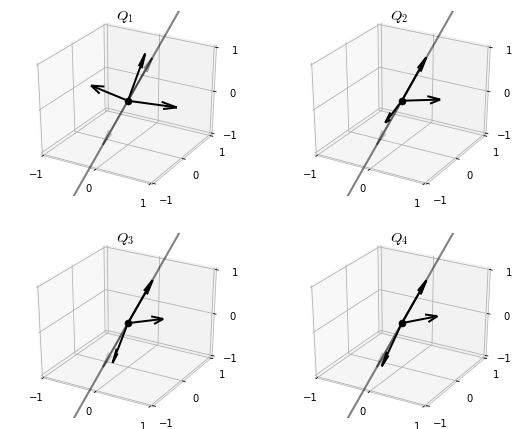

In [28]:
fig = plt.figure(figsize=(12*0.75, 10*0.75))

for i, Q in enumerate(basies[:4]):
    ax = fig.add_subplot(2, 2, i+1, projection='3d', facecolor='white')
    plot_basis(ax, Q, basies[-1])
    ax.set_title("$Q_{{{}}}$".format(i+1))

## Simultaneous Orthogonalization

In [29]:
Q, basies = simultaneous_orthogonalization(A)
Q

array([[ -3.700e-04,   8.001e-01,  -5.999e-01],
       [ -7.998e-01,  -3.603e-01,  -4.800e-01],
       [ -6.002e-01,   4.796e-01,   6.401e-01]])

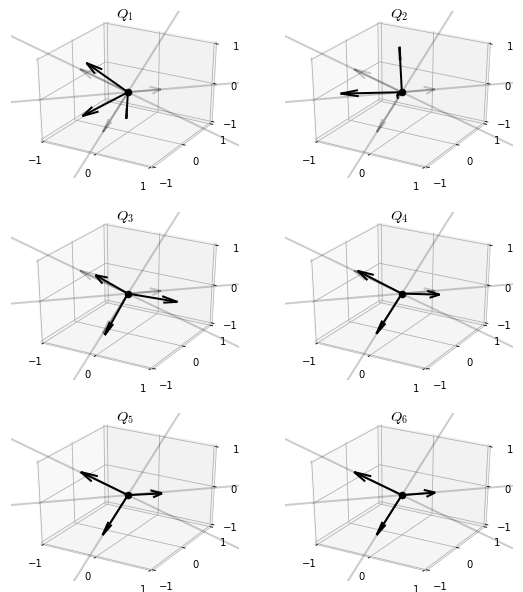

In [30]:
fig = plt.figure(figsize=(12*0.75, 14*0.75))

for i, Q in enumerate(basies[:6]):
    ax = fig.add_subplot(3, 2, i+1, projection='3d', facecolor='white')
    plot_basis(ax, Q, basies[-1])
    ax.set_title("$Q_{{{}}}$".format(i+1))

## QR Algorithm

In [31]:
Q, basies = qr_algorithm(A)
Q

array([[ -1.000e+00,   7.396e-12,  -2.095e-09],
       [ -7.396e-12,  -1.000e+00,  -3.643e-14],
       [ -2.095e-09,  -3.643e-14,   1.000e+00]])

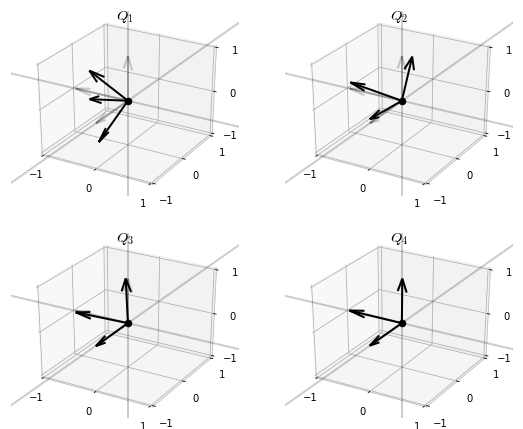

In [32]:
fig = plt.figure(figsize=(12*0.75, 10*0.75))

for i, Q in enumerate(basies[:4]):
    ax = fig.add_subplot(2, 2, i+1, projection='3d', facecolor='white')
    plot_basis(ax, Q, basies[-1])
    ax.set_title("$Q_{{{}}}$".format(i+1))